In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
import itertools
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from patsy import dmatrices

In [3]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
data=pd.read_excel('Data Set.xlsx')

In [5]:
data.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
region,5000.0,3.001400,1.421760,1.0,2.0,3.0,4.0,5.0
townsize,4998.0,2.687275,1.425925,1.0,1.0,3.0,4.0,5.0
gender,5000.0,0.503600,0.500037,0.0,0.0,1.0,1.0,1.0
age,5000.0,47.025600,17.770338,18.0,31.0,47.0,62.0,79.0
agecat,5000.0,4.238800,1.308785,2.0,3.0,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.178800,0.383223,0.0,0.0,0.0,0.0,1.0
news,5000.0,0.472600,0.499299,0.0,0.0,0.0,1.0,1.0
response_01,5000.0,0.083600,0.276815,0.0,0.0,0.0,0.0,1.0
response_02,5000.0,0.129800,0.336117,0.0,0.0,0.0,0.0,1.0


In [7]:
data.shape

(5000, 130)

In [8]:
data['Total_Spend']=data.cardspent+data.card2spent
data.drop(['custid','cardspent','card2spent'],axis=1,inplace=True)

### Basic Exploratory Analysis

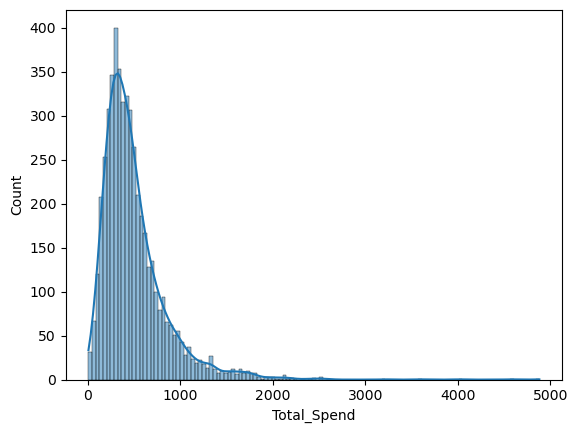

In [9]:
# Check normal distribution
sns.histplot(data.Total_Spend,kde=True)
plt.show()

In [10]:
# Normalising by log
data['log_Total_Spend']=np.log(data['Total_Spend'])

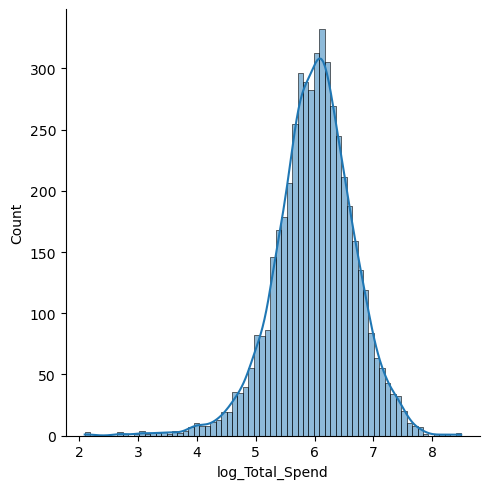

In [11]:
sns.displot(data.log_Total_Spend,kde=True)
plt.show()

In [12]:
numeric_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object', 'O']]

In [13]:
numeric_var_names

['region',
 'townsize',
 'gender',
 'age',
 'agecat',
 'ed',
 'edcat',
 'jobcat',
 'union',
 'employ',
 'empcat',
 'retire',
 'income',
 'lninc',
 'inccat',
 'debtinc',
 'creddebt',
 'lncreddebt',
 'othdebt',
 'lnothdebt',
 'default',
 'jobsat',
 'marital',
 'spoused',
 'spousedcat',
 'reside',
 'pets',
 'pets_cats',
 'pets_dogs',
 'pets_birds',
 'pets_reptiles',
 'pets_small',
 'pets_saltfish',
 'pets_freshfish',
 'homeown',
 'hometype',
 'address',
 'addresscat',
 'cars',
 'carown',
 'cartype',
 'carvalue',
 'carcatvalue',
 'carbought',
 'carbuy',
 'commute',
 'commutecat',
 'commutetime',
 'commutecar',
 'commutemotorcycle',
 'commutecarpool',
 'commutebus',
 'commuterail',
 'commutepublic',
 'commutebike',
 'commutewalk',
 'commutenonmotor',
 'telecommute',
 'reason',
 'polview',
 'polparty',
 'polcontrib',
 'vote',
 'card',
 'cardtype',
 'cardbenefit',
 'cardfee',
 'cardtenure',
 'cardtenurecat',
 'card2',
 'card2type',
 'card2benefit',
 'card2fee',
 'card2tenure',
 'card2tenureca

In [14]:
cat_var_names       # birthmonth is not important in prediction . So ,we do not use birthmonth

['birthmonth']

In [15]:
data_num=data[numeric_var_names]
data_num.head(5)

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_Spend,log_Total_Spend
0,1,2.0,1,20,2,15,3,1,1,0,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5.0,0,22,2,17,4,2,0,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4.0,1,67,6,14,2,2,0,16,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3.0,0,23,2,16,3,2,0,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2.0,0,26,3,16,3,2,0,1,...,1,0,1,0,0,0,1,0,507.83,6.230147


### Data Audit Report

In [16]:
# Creating Data audit Report
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.std()/x.mean(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

data_num.apply(var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,CV,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,5000.0,0.0,1.500700e+04,3.001400,3.00000,1.421760,2.021402,0.473699,1.000000,1.000000,1.000000,1.000000,2.000000,3.00000,4.000000,5.000000,5.000000,5.000000,5.000000
townsize,4998.0,2.0,1.343100e+04,2.687275,3.00000,1.425925,2.033262,0.530621,1.000000,1.000000,1.000000,1.000000,1.000000,3.00000,4.000000,5.000000,5.000000,5.000000,5.000000
gender,5000.0,0.0,2.518000e+03,0.503600,1.00000,0.500037,0.250037,0.992925,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
age,5000.0,0.0,2.351280e+05,47.025600,47.00000,17.770338,315.784902,0.377886,18.000000,18.000000,20.000000,23.000000,31.000000,47.00000,62.000000,72.000000,76.000000,79.000000,79.000000
agecat,5000.0,0.0,2.119400e+04,4.238800,4.00000,1.308785,1.712917,0.308763,2.000000,2.000000,2.000000,2.000000,3.000000,4.00000,5.000000,6.000000,6.000000,6.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
response_01,5000.0,0.0,4.180000e+02,0.083600,0.00000,0.276815,0.076626,3.311180,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000
response_02,5000.0,0.0,6.490000e+02,0.129800,0.00000,0.336117,0.112975,2.589498,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000
response_03,5000.0,0.0,5.130000e+02,0.102600,0.00000,0.303466,0.092092,2.957759,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000
Total_Spend,5000.0,0.0,2.490393e+06,498.078630,414.25000,351.529270,123572.827720,0.705771,8.110000,58.197600,133.106000,184.033000,276.282500,414.25000,615.562500,908.125000,1145.146500,1760.102400,4881.050000


In [17]:
num_summary=data_num.apply(var_summary).T
num_summary.to_csv('num_summary.csv')

### Handling Outlier

In [18]:
#Handling Outliers
def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

data_num=data_num.apply(outlier_capping)

### Handling Missing

In [19]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_num=data_num.apply(Missing_imputation)

### Final file for analysis

In [20]:
data_new = data_num
data_new.head()

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_Spend,log_Total_Spend
0,1,2.0,1,20,2,15,3,1,1,0,...,0,1,1,0,0,0,1,0,149.46,5.007029
1,5,5.0,0,22,2,17,4,2,0,0,...,1,1,1,1,1,0,0,0,77.54,4.350794
2,3,4.0,1,67,6,14,2,2,0,16,...,0,0,0,0,1,0,0,0,359.97,5.886021
3,4,3.0,0,23,2,16,3,2,0,0,...,1,1,1,0,1,1,0,0,359.41,5.884464
4,2,2.0,0,26,3,16,3,2,0,1,...,1,0,1,0,0,0,1,0,507.83,6.230147


In [21]:
# correlation matrix (ranges from 1 to -1)
corrm=data_new.corr()
corrm.to_csv('corrm.csv')
corrm

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,...,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,Total_Spend,log_Total_Spend
region,1.000000,0.414026,-0.012810,-0.026525,-0.018455,0.013850,0.015710,-0.004717,-0.013768,-0.010204,...,0.020596,0.007504,0.026391,0.036622,0.012312,-0.013004,0.005899,0.005694,0.042694,0.039216
townsize,0.414026,1.000000,0.009576,-0.075399,-0.069017,0.002968,0.003744,-0.010768,-0.019846,-0.059221,...,0.002639,0.005333,0.007898,-0.000562,-0.028756,-0.006252,-0.010070,-0.007230,-0.008651,0.006132
gender,-0.012810,0.009576,1.000000,-0.010186,-0.007427,-0.000777,-0.002673,-0.016470,0.000311,-0.011756,...,-0.006963,-0.021319,0.001164,0.009167,-0.020837,0.018058,0.001385,-0.009685,-0.077512,-0.078605
age,-0.026525,-0.075399,-0.010186,1.000000,0.969879,-0.093966,-0.081129,0.037709,0.011206,0.705515,...,-0.133284,-0.217524,-0.235226,-0.042090,0.365204,0.015140,0.013175,-0.026231,0.031680,0.007270
agecat,-0.018455,-0.069017,-0.007427,0.969879,1.000000,-0.078331,-0.064124,0.032554,0.004465,0.679902,...,-0.123192,-0.208690,-0.223387,-0.029310,0.348275,0.010039,0.010467,-0.014860,0.051619,0.030192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
response_01,-0.013004,-0.006252,0.018058,0.015140,0.010039,-0.117333,-0.112653,0.000137,-0.010492,0.039085,...,-0.107194,-0.069870,-0.096176,-0.014592,0.020919,1.000000,-0.015601,-0.018781,-0.008449,-0.009182
response_02,0.005899,-0.010070,0.001385,0.013175,0.010467,0.073750,0.070172,0.002888,0.006431,0.014410,...,0.039891,0.015485,0.011744,0.032549,0.030136,-0.015601,1.000000,0.028266,0.023892,0.026831
response_03,0.005694,-0.007230,-0.009685,-0.026231,-0.014860,0.107912,0.106223,-0.008415,0.004479,-0.029312,...,0.089388,0.072791,0.094278,0.093360,-0.011148,-0.018781,0.028266,1.000000,0.051291,0.061573
Total_Spend,0.042694,-0.008651,-0.077512,0.031680,0.051619,0.100943,0.098842,0.002436,0.011456,0.091386,...,0.050454,0.030406,0.026851,0.060171,0.041757,-0.008449,0.023892,0.051291,1.000000,0.909423


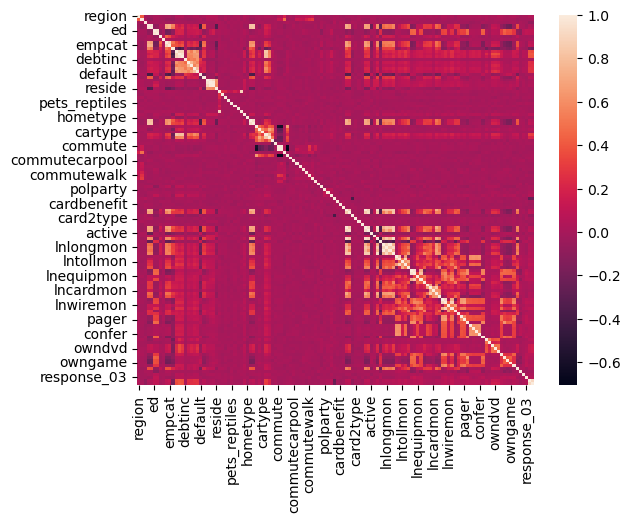

In [22]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(data_new.corr())
plt.show()

#### Dropping columns based on data audit report
        - Based on low variance (near zero variance)
        - High missings (>25% missings)
        - High correlations between two numerical variables

In [23]:
# Low variance
data_new.drop(columns=['commutemotorcycle','commutepublic','commutenonmotor'],axis=1,inplace=True)

In [24]:
# High missing
data_new.drop(columns=['lncardten'],axis=1,inplace=True)

In [25]:
# High correlation
data_new.drop(columns=['response_01','commutecat'],axis=1,inplace=True)

In [26]:
data_new.shape

(5000, 122)

#### Feature Selection based on importance using F-Regression

In [27]:
# Feature Selection based on importance
features = data_new[data_new.columns.difference(['log_Total_Spend','Total_Spend'])]
target = data_new['log_Total_Spend']
F_values, p_values  = f_regression(features, target )

In [28]:
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results.loc[80:]

,Variable,F_Value,P_Value
80,owndvd,138.282716,0.000
81,ownfax,19.784973,0.000
82,owngame,8.693023,0.003
83,ownipod,8.424830,0.004
84,ownpc,9.851560,0.002
85,ownpda,24.646407,0.000
86,owntv,36.512224,0.000
87,ownvcr,125.995381,0.000
88,pager,16.789264,0.000
89,pets,0.112238,0.738


In [29]:
f_reg_results.sort_values(by=['P_Value'])
f_reg_results.P_Value = pd.to_numeric(f_reg_results.P_Value)
f_reg_results_new=f_reg_results[f_reg_results.P_Value<=0.1]
f_reg_results_new

,Variable,F_Value,P_Value
1,address,11.355096,0.001
2,addresscat,27.886843,0.000
4,agecat,4.560250,0.033
5,bfast,4.065689,0.044
7,callid,15.603747,0.000
...,...,...,...
115,voice,10.132465,0.001
116,vote,15.628862,0.000
117,wireless,27.549439,0.000
118,wiremon,38.275030,0.000


#### Variable Reduction using Recursive Feature Elimination

In [30]:
ligreg = LinearRegression()
rfe = RFE(estimator=ligreg, n_features_to_select=15)
rfe = rfe.fit(features, target )
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False  True False False False False False False False
 False  True False  True False  True False False False False False  True
 False False False False False False False False  True  True False False
 False False  True False False False False False False False  True  True
 False False False False False False False False  True False False False
 False False False False False False False  True False False False False]
[ 19  73  29  72  49  80  20  34  97   6  25  23   1   1  75   2  93  65
  78  99  41 100 103  94   8  77  22  70  55  90  17  79   9  24  15  16
  38  89  50  33  86  95   1  11  81  32  48  96  46  47 102  68   1  28
  27  85  37 105  12  31  44   1  51   1  36   1  

In [31]:
feature_map = [(i, v) for i, v in itertools.zip_longest(features.columns, rfe.get_support())]

feature_map

#Alternative of capturing the important variables
RFE_features=features.columns[rfe.get_support()]

selected_features_from_rfe = features[RFE_features]

In [32]:
RFE_features

Index(['card', 'card2', 'default', 'gender', 'lncardmon', 'lnequipmon',
       'lninc', 'lnwiremon', 'owndvd', 'ownfax', 'owntv', 'pets_reptiles',
       'pets_saltfish', 'response_03', 'voice'],
      dtype='object')

#### Variable reduction using Select K-Best technique

In [33]:
X_new = SelectKBest(f_classif, k=15).fit(features, target )

In [34]:
X_new.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [35]:
X_new.scores_

array([0.99558822, 0.92536224, 0.96810654, 0.90102018, 0.97085501,
       1.08477987, 1.04965806, 0.96246007, 0.94495912, 0.97175901,
       1.00279754, 1.08036098, 1.10262509, 1.19796941, 1.15461919,
       1.10060702, 1.02745464, 1.09267391, 0.90447528, 1.01883609,
       0.96917035, 0.96847512, 0.98360157, 1.01073485, 1.03350843,
       0.95537703, 1.06514188, 1.11380553, 1.01612211, 1.03295509,
       1.12647526, 1.0161885 , 1.10381263, 0.95756014, 0.98967281,
       1.08831692, 1.00918474, 1.07587409, 0.96001115, 0.94425906,
       1.0968984 , 1.08891051, 1.38527749, 1.0836507 , 1.23246133,
       1.21112998, 1.05898102, 0.89683123, 1.04516152, 0.9505109 ,
       0.81683679, 0.89335496, 1.03391763, 0.99849439, 0.95652301,
       0.97615846, 1.27823138, 0.87840249, 1.08031759, 0.99283896,
       0.91835811, 1.04651155, 1.23196921, 0.82458932, 1.14113741,
       1.12062586, 1.08425725, 1.16052171, 1.16172981, 1.18947344,
       1.37732299, 0.89692194, 1.34423878, 1.10621556, 1.10025

In [36]:
feature_map = [(i, v) for i, v in itertools.zip_longest(features.columns, X_new.get_support())]

feature_map

#Alternative of capturing the important variables
KBest_features=features.columns[X_new.get_support()]

selected_features_from_KBest = features[KBest_features]

In [37]:
KBest_features

Index(['card2', 'card2benefit', 'default', 'ed', 'edcat', 'inccat',
       'lncreddebt', 'lnlongten', 'lnothdebt', 'lntollmon', 'lntollten',
       'lnwireten', 'ownpda', 'pets_saltfish', 'response_03'],
      dtype='object')

#### Variance Inflation Factor assessment

In [38]:
X = pd.concat([features,target], axis=1)
features = "+".join(data_new.columns.difference(['log_Total_Spend','Total_Spend']))
X.head()

,active,address,addresscat,age,agecat,bfast,callcard,callid,callwait,carbought,...,tollmon,tollten,townsize,union,voice,vote,wireless,wiremon,wireten,log_Total_Spend
0,0,0,1,20,2,3,1,0,1,0,...,29.0,161.05,2.0,1,1,1,0,0.00,0.00,5.007029
1,1,2,1,22,2,1,1,1,0,0,...,0.0,0.00,5.0,0,1,0,1,45.65,1683.55,4.350794
2,0,30,5,67,6,3,1,0,0,0,...,0.0,0.00,4.0,0,0,0,0,0.00,0.00,5.886021
3,1,3,2,23,2,1,1,0,0,0,...,0.0,0.00,3.0,0,0,0,0,0.00,0.00,5.884464
4,1,3,2,26,3,3,1,1,1,0,...,16.5,387.70,2.0,0,1,0,1,19.05,410.80,6.230147


In [39]:
features

'active+address+addresscat+age+agecat+bfast+callcard+callid+callwait+carbought+carbuy+carcatvalue+card+card2+card2benefit+card2fee+card2tenure+card2tenurecat+card2type+cardbenefit+cardfee+cardmon+cardten+cardtenure+cardtenurecat+cardtype+carown+cars+cartype+carvalue+churn+commute+commutebike+commutebus+commutecar+commutecarpool+commuterail+commutetime+commutewalk+confer+creddebt+debtinc+default+ebill+ed+edcat+empcat+employ+equip+equipmon+equipten+forward+gender+homeown+hometype+hourstv+inccat+income+internet+jobcat+jobsat+lncardmon+lncreddebt+lnequipmon+lnequipten+lninc+lnlongmon+lnlongten+lnothdebt+lntollmon+lntollten+lnwiremon+lnwireten+longmon+longten+marital+multline+news+othdebt+owncd+owndvd+ownfax+owngame+ownipod+ownpc+ownpda+owntv+ownvcr+pager+pets+pets_birds+pets_cats+pets_dogs+pets_freshfish+pets_reptiles+pets_saltfish+pets_small+polcontrib+polparty+polview+reason+region+reside+response_02+response_03+retire+spoused+spousedcat+telecommute+tenure+tollfree+tollmon+tollten+townsi

In [40]:
a,b = dmatrices(formula_like='log_Total_Spend ~ '+ 'active+address+addresscat+age+agecat+bfast+callcard+callid+callwait+carbought+carbuy+carcatvalue+card+card2+card2benefit+card2fee+card2tenure+card2tenurecat+card2type+cardbenefit+cardfee+cardmon+cardten+cardtenure+cardtenurecat+cardtype+carown+cars+cartype+carvalue+churn+commute+commutebike+commutebus+commutecar+commutecarpool+commuterail+commutetime+commutewalk+confer+creddebt+debtinc+default+ebill+ed+edcat+empcat+employ+equip+equipmon+equipten+forward+gender+homeown+hometype+hourstv+inccat+income+internet+jobcat+jobsat+lncardmon+lncreddebt+lnequipmon+lnequipten+lninc+lnlongmon+lnlongten+lnothdebt+lntollmon+lntollten+lnwiremon+lnwireten+longmon+longten+marital+multline+news+othdebt+owncd+owndvd+ownfax+owngame+ownipod+ownpc+ownpda+owntv+ownvcr+pager+pets+pets_birds+pets_cats+pets_dogs+pets_freshfish+pets_reptiles+pets_saltfish+pets_small+polcontrib+polparty+polview+reason+region+reside+response_02+response_03+retire+spoused+spousedcat+telecommute+tenure+tollfree+tollmon+tollten+townsize+union+voice+vote+wireless+wiremon+wireten', data = data_new, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

       VIF Factor    features
0    39912.437874   Intercept
1        1.125175      active
2        9.884650     address
3       10.446187  addresscat
4       24.306126         age
..            ...         ...
116      2.217453       voice
117      1.061896        vote
118    182.419988    wireless
119    270.959326     wiremon
120     25.943318     wireten

[121 rows x 2 columns]


### Final list of variable selected for the model building from above steps

'active+address+addresscat+age+agecat+bfast+callcard+callid+callwait+carbought+carbuy+carcatvalue+card+card2+card2benefit+card2fee+card2tenure+card2tenurecat+card2type+cardbenefit+cardfee+cardmon+cardten+cardtenure+cardtenurecat+cardtype+carown+cars+cartype+carvalue+churn+commute+commutebike+commutebus+commutecar+commutecarpool+commuterail+commutetime+commutewalk+confer+creddebt+debtinc+default+ebill+ed+edcat+empcat+employ+equip+equipmon+equipten+forward+gender+homeown+hometype+hourstv+inccat+income+internet+jobcat+jobsat+lncardmon+lncreddebt+lnequipmon+lnequipten+lninc+lnlongmon+lnlongten+lnothdebt+lntollmon+lntollten+lnwiremon+lnwireten+longmon+longten+marital+multline+news+othdebt+owncd+owndvd+ownfax+owngame+ownipod+ownpc+ownpda+owntv+ownvcr+pager+pets+pets_birds+pets_cats+pets_dogs+pets_freshfish+pets_reptiles+pets_saltfish+pets_small+polcontrib+polparty+polview+reason+region+reside+response_02+response_03+retire+spoused+spousedcat+telecommute+tenure+tollfree+tollmon+tollten+townsize+union+voice+vote+wireless+wiremon+wireten'

In [41]:
feature_columns=['active','address','addresscat','age','agecat','bfast','callcard','callid','callwait','carbought','carbuy','carcatvalue','card','card2','card2benefit','card2fee','card2tenure','card2tenurecat','card2type','cardbenefit','cardfee','cardmon','cardten','cardtenure','cardtenurecat','cardtype','carown','cars','cartype','carvalue','churn','commute','commutebike','commutebus','commutecar','commutecarpool','commuterail','commutetime','commutewalk','confer','creddebt','debtinc','default','ebill','ed','edcat','empcat','employ','equip','equipmon','equipten','forward','gender','homeown','hometype','hourstv','inccat','income','internet','jobcat','jobsat','lncardmon','lncreddebt','lnequipmon','lnequipten','lninc','lnlongmon','lnlongten','lnothdebt','lntollmon','lntollten','lnwiremon','lnwireten','longmon','longten','marital','multline','news','othdebt','owncd','owndvd','ownfax','owngame','ownipod','ownpc','ownpda','owntv','ownvcr','pager','pets','pets_birds','pets_cats','pets_dogs','pets_freshfish','pets_reptiles','pets_saltfish','pets_small','polcontrib','polparty','polview','reason','region','reside','response_02','response_03','retire','spoused','spousedcat','telecommute','tenure','tollfree','tollmon','tollten','townsize','union','voice','vote','wireless','wiremon','wireten']

In [42]:
data_new=pd.concat([data_new[feature_columns],data_new['log_Total_Spend']],axis=1)

### Apply Transformation

In [43]:
y=data_new.log_Total_Spend
def corr_check(x):
    c1=y.corr(x)
    c2=y.corr(np.log(x+1))
    c3=y.corr(np.sqrt(x))
    c4=y.corr(np.square(x))
    c5=y.corr(np.cbrt(x))
    res=pd.Series([c1,c2,c3,c4,c5],index=['x','log_x','sqrt_x','sq_x','cbrt_x'])
    return res

corr_advanced=data_new.apply(corr_check)
corr_advanced=corr_advanced.T

C:\Users\vg606\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\vg606\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\vg606\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\vg606\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\vg606\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\vg606\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*in

In [44]:
corr_advanced

,x,log_x,sqrt_x,sq_x,cbrt_x
active,-0.004454,-0.004454,-0.004454,-0.004454,-0.004454
address,0.047611,0.090261,0.074661,0.013326,0.084797
addresscat,0.074489,0.084576,0.081751,0.059356,0.083928
age,0.007270,0.040056,0.024209,-0.024673,0.029830
agecat,0.030192,0.049023,0.042262,0.006428,0.046194
...,...,...,...,...,...
vote,0.055833,0.055833,0.055833,0.055833,0.055833
wireless,0.074040,0.074040,0.074040,0.074040,0.074040
wiremon,0.087177,0.079042,0.082582,0.086781,0.080157
wireten,0.097513,0.085286,0.096367,0.087110,0.092804


#### Choose variable transformation according to higher correlation value.

Variables to not transform : 
active, callcard, callid, callwait, carbuy, card2fee, cardfee, commutebike, confer, ebill, ed, edcat, equip, forward, gender, homeown, multline, news, owncd, owndvd, ownfax, owngame, ownipod, ownpc, ownpda, owntv, ownvcr, pager, polcontrib, response_02, response_03, retire, tollfree, tollten, voice, vote, wireless, wiremon, wireten, lncreddebt, lnlongten, lnothdebt

Variables to transform to log : 
address, addresscat, agecat, card, card2, card2tenurecat, cardtenure, cardtenurecat, empcat, employ, longten, othdebt, tenure, hourstv, income, lnlongmon, longmon, longten

In [45]:
data_new['log_address']=data_new['address'].apply(lambda x:np.log(x+1))
data_new['log_addresscat']=data_new['addresscat'].apply(lambda x:np.log(x+1))
data_new['log_age']=data_new['age'].apply(lambda x:np.log(x+1))
data_new['log_agecat']=data_new['agecat'].apply(lambda x:np.log(x+1))
data_new['log_card']=data_new['card'].apply(lambda x:np.log(x+1))
data_new['log_card2']=data_new['card2'].apply(lambda x:np.log(x+1))
data_new['log_card2benefit']=data_new['card2benefit'].apply(lambda x:np.log(x+1))
data_new['log_card2tenurecat']=data_new['card2tenurecat'].apply(lambda x:np.log(x+1))
data_new['log_cardbenefit']=data_new['cardbenefit'].apply(lambda x:np.log(x+1))
data_new['log_cardmon']=data_new['cardmon'].apply(lambda x:np.log(x+1))
data_new['log_cardtenure']=data_new['cardtenure'].apply(lambda x:np.log(x+1))
data_new['log_cardtenurecat']=data_new['cardtenurecat'].apply(lambda x:np.log(x+1))
data_new['log_empcat']=data_new['empcat'].apply(lambda x:np.log(x+1))
data_new['log_employ']=data_new['employ'].apply(lambda x:np.log(x+1))
data_new['log_longten']=data_new['longten'].apply(lambda x:np.log(x+1))
data_new['log_othdebt']=data_new['othdebt'].apply(lambda x:np.log(x+1))
data_new['log_tenure']=data_new['tenure'].apply(lambda x:np.log(x+1))
data_new['log_hourstv']=data_new['hourstv'].apply(lambda x:np.log(x+1))
data_new['log_income']=data_new['income'].apply(lambda x:np.log(x+1))
data_new['log_lnlongmon']=data_new['lnlongmon'].apply(lambda x:np.log(x+1))
data_new['log_longmon']=data_new['longmon'].apply(lambda x:np.log(x+1))
data_new['log_longten']=data_new['longten'].apply(lambda x:np.log(x+1))

Variables to transform to square root : 
carcatvalue, cardten, carown, carvalue, spoused, spousedcat, inccat, jobsat

In [46]:
data_new['sqrt_carcatvalue']=data_new['carcatvalue'].apply(lambda x:np.sqrt(x))
data_new['sqrt_cardten']=data_new['cardten'].apply(lambda x:np.sqrt(x))
data_new['sqrt_carown']=data_new['carown'].apply(lambda x:np.sqrt(x))
data_new['sqrt_carvalue']=data_new['carvalue'].apply(lambda x:np.sqrt(x))
data_new['sqrt_spoused']=data_new['spoused'].apply(lambda x:np.sqrt(x))
data_new['sqrt_spousedcat']=data_new['spousedcat'].apply(lambda x:np.sqrt(x))
data_new['sqrt_inccat']=data_new['inccat'].apply(lambda x:np.sqrt(x))
data_new['sqrt_jobsat']=data_new['jobsat'].apply(lambda x:np.sqrt(x))

C:\Users\vg606\AppData\Local\Temp\ipykernel_18436\3708668688.py:1: RuntimeWarning: invalid value encountered in sqrt
  data_new['sqrt_carcatvalue']=data_new['carcatvalue'].apply(lambda x:np.sqrt(x))
C:\Users\vg606\AppData\Local\Temp\ipykernel_18436\3708668688.py:3: RuntimeWarning: invalid value encountered in sqrt
  data_new['sqrt_carown']=data_new['carown'].apply(lambda x:np.sqrt(x))
C:\Users\vg606\AppData\Local\Temp\ipykernel_18436\3708668688.py:4: RuntimeWarning: invalid value encountered in sqrt
  data_new['sqrt_carvalue']=data_new['carvalue'].apply(lambda x:np.sqrt(x))
C:\Users\vg606\AppData\Local\Temp\ipykernel_18436\3708668688.py:5: RuntimeWarning: invalid value encountered in sqrt
  data_new['sqrt_spoused']=data_new['spoused'].apply(lambda x:np.sqrt(x))
C:\Users\vg606\AppData\Local\Temp\ipykernel_18436\3708668688.py:6: RuntimeWarning: invalid value encountered in sqrt
  data_new['sqrt_spousedcat']=data_new['spousedcat'].apply(lambda x:np.sqrt(x))


variables to transform to square : 
bfast, equipmon, equipten, tollmon, internet, lnequipmon, lnequipten, lntollmon, lntollten, lnwiremon

In [47]:
data_new['sq_bfast']=data_new['bfast'].apply(lambda x:np.square(x))
data_new['sq_carbought']=data_new['carbought'].apply(lambda x:np.square(x))
data_new['sq_cardtype']=data_new['cardtype'].apply(lambda x:np.square(x))
data_new['sq_cars']=data_new['cars'].apply(lambda x:np.square(x))
data_new['sq_equipmon']=data_new['equipmon'].apply(lambda x:np.square(x))
data_new['sq_equipten']=data_new['equipten'].apply(lambda x:np.square(x))
data_new['sq_tollmon']=data_new['tollmon'].apply(lambda x:np.square(x))
data_new['sq_internet']=data_new['internet'].apply(lambda x:np.square(x))
data_new['sq_lnequipmon']=data_new['lnequipmon'].apply(lambda x:np.square(x))
data_new['sq_lnequipten']=data_new['lnequipten'].apply(lambda x:np.square(x))
data_new['sq_lntollmon']=data_new['lntollmon'].apply(lambda x:np.square(x))
data_new['sq_lntollten']=data_new['lntollten'].apply(lambda x:np.square(x))
data_new['sq_lnwiremon']=data_new['lnwiremon'].apply(lambda x:np.square(x))

variables to transform to cube root : 
card2tenure, creddebt, region, lninc

In [48]:
data_new['cbrt_card2tenure']=data_new['card2tenure'].apply(lambda x:np.cbrt(x))
data_new['cbrt_card2type']=data_new['card2type'].apply(lambda x:np.cbrt(x))
data_new['cbrt_creddebt']=data_new['creddebt'].apply(lambda x:np.cbrt(x))
data_new['cbrt_region']=data_new['region'].apply(lambda x:np.cbrt(x))
data_new['cbrt_lninc']=data_new['lninc'].apply(lambda x:np.cbrt(x))

### Building a linear regression model

In [49]:
train, test = train_test_split( data_new,test_size = 0.3,random_state = 1234 )

In [50]:
print(len( train))
print(len( test))

3500
1500


In [51]:
lm = smf.ols("log_Total_Spend~callid+callwait+commutebike+confer+ebill+ed+edcat+equip+forward+gender+homeown+multline+news+owncd+owndvd+ownfax+owngame+ownipod+ownpc+ownpda+owntv+ownvcr+pager+polcontrib+response_02+response_03+retire+tollfree+tollten+voice+vote+wireless+wiremon+wireten+lncreddebt+lnlongten+lnothdebt+log_address+log_addresscat+log_agecat+log_card+log_card2+log_card2tenurecat+log_cardtenure+log_cardtenurecat+log_empcat+log_employ+log_longten+log_othdebt+log_tenure+log_hourstv+log_income+log_lnlongmon+log_longmon+log_longten+sqrt_carcatvalue+sqrt_cardten+sqrt_carown+sqrt_carvalue+sqrt_spoused+sqrt_spousedcat+sqrt_inccat+sqrt_jobsat+sq_bfast+sq_equipmon+sq_equipten+sq_tollmon+sq_internet+sq_lnequipmon+sq_lnequipten+sq_lntollmon+sq_lntollten+sq_lnwiremon+cbrt_card2tenure+cbrt_creddebt+cbrt_region+cbrt_lninc", data=train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_Spend   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     10.03
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           7.06e-88
Time:                        00:25:26   Log-Likelihood:                -1189.2
No. Observations:                1540   AIC:                             2532.
Df Residuals:                    1463   BIC:                             2944.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.5154      2

#### Reduce the variables to 15 by p-value.

In [52]:
lm = smf.ols("log_Total_Spend~gender+ownvcr+voice+wireten+log_card+log_card2+log_cardtenure+log_longten+log_tenure+log_income+log_lnlongmon+log_longten+sqrt_cardten+sqrt_spoused+sqrt_spousedcat+sq_internet", data=train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Total_Spend   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     51.62
Date:                Sun, 22 Feb 2026   Prob (F-statistic):          1.23e-126
Time:                        00:25:28   Log-Likelihood:                -1341.6
No. Observations:                1706   AIC:                             2715.
Df Residuals:                    1690   BIC:                             2802.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7170      0.280     

### Final list of variable selected for the model building from above steps

gender, ownvcr, voice, wireten, log_card, log_card2, log_cardtenure, log_longten, log_tenure, log_income, log_lnlongmon, sqrt_cardten, sqrt_spoused, sqrt_spousedcat, sq_internet

In [53]:
feature_columns=['gender', 'ownvcr', 'voice', 'wireten', 'log_card', 'log_card2', 'log_cardtenure', 'log_longten', 
                 'log_tenure', 'log_income', 'log_lnlongmon', 'sqrt_cardten', 'sqrt_spoused', 'sqrt_spousedcat', 'sq_internet']

data_new=pd.concat([data_new[feature_columns],data_new['log_Total_Spend']],axis=1)

In [54]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

data_new=data_new.apply(Missing_imputation)

In [55]:
train, test = train_test_split( data_new,test_size = 0.3,random_state = 1234 )

In [56]:
lm.predict(train)

4735    6.240865
1796    6.435741
479     6.279900
2524    6.411940
1565    6.132713
          ...   
664     5.888830
3276    5.727449
1318    6.146643
723     5.766932
2863    6.719157
Length: 3500, dtype: float64

#### Predict the Y (Scoring the train & test and validate the results)

In [57]:
pd.set_option('mode.chained_assignment', None)  # For SettingWithCopyWarning
train.loc[:,'pred_ln_spend'] = lm.predict(train)
test.loc[:,'pred_ln_spend']  = lm.predict(test)

In [58]:
pd.set_option('mode.chained_assignment', None)  # For SettingWithCopyWarning
train.loc[:,'actual_spend'] = np.exp(train.log_Total_Spend)
test.loc[:,'actual_spend'] = np.exp(test.log_Total_Spend)

train.loc[:,'pred_spend'] = np.exp(train.pred_ln_spend)
test.loc[:,'pred_spend'] = np.exp(test.pred_ln_spend)

### Accuracy Metrics

In [59]:
#Train Data
MAPE_train = np.mean(np.abs(train.actual_spend - train.pred_spend)/train.actual_spend )
print(MAPE_train)

#Test Data
MAPE_test = np.mean(np.abs(test.actual_spend - test.pred_spend)/test.actual_spend )
print(MAPE_test)

0.49172041171478453
0.5000110201312093


In [60]:
# mean squared error
mse = np.sum((train.pred_spend - train.actual_spend)**2)
print('mean squared error : ',mse)

# root mean squared error
rmse = np.sqrt(mse/train.pred_spend.shape[0])
print('root mean squared error : ',rmse)

mean squared error :  281288653.2293923
root mean squared error :  283.49283348432147


In [61]:
# sum of square of residuals
ssr = np.sum((train.pred_spend - train.actual_spend)**2)
print('sum of square of residuals : ',ssr)

#  total sum of squares
sst = np.sum((train.actual_spend - np.mean(train.actual_spend))**2)
print('total sum of squares : ',sst)

# R2 score
r2_score = 1 - (ssr/sst)
print('R2 score : ',r2_score)

sum of square of residuals :  281288653.2293923
total sum of squares :  378619286.32325196
R2 score :  0.25706728793197864


### Decile Analysis for Linear Regression

In [62]:
train.columns

Index(['gender', 'ownvcr', 'voice', 'wireten', 'log_card', 'log_card2',
       'log_cardtenure', 'log_longten', 'log_tenure', 'log_income',
       'log_lnlongmon', 'sqrt_cardten', 'sqrt_spoused', 'sqrt_spousedcat',
       'sq_internet', 'log_Total_Spend', 'pred_ln_spend', 'actual_spend',
       'pred_spend'],
      dtype='object')

In [63]:
### Decile Analysis
#Decile analysis for validation of models - Business validation
pd.set_option('mode.chained_assignment', None)  # For SettingWithCopyWarning
train.loc[:,'Deciles']=pd.qcut(train.pred_spend,10, labels=False)
test.loc[:,'Deciles']=pd.qcut(test.pred_spend,10, labels=False)

In [64]:
# Decile Analysis for train data
Predicted_avg = train[['Deciles','pred_spend']].groupby(train.Deciles).mean().sort_index(ascending=False)['pred_spend']
Actual_avg = train[['Deciles','actual_spend']].groupby(train.Deciles).mean().sort_index(ascending=False)['actual_spend']

Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis=1)

Decile_analysis_train

,pred_spend,actual_spend
Deciles,,
9,774.163755,889.749552
8,591.601117,684.752823
7,509.197596,580.021869
6,456.000001,542.636041
5,415.610242,465.724935
4,379.366768,427.916529
3,346.222993,412.546030
2,312.275011,346.570244
1,271.649152,337.061624


In [65]:
# Decile Analysis for test data
Predicted_avg = test[['Deciles','pred_spend']].groupby(test.Deciles).mean().sort_index(ascending=False)['pred_spend']
Actual_avg = test[['Deciles','actual_spend']].groupby(test.Deciles).mean().sort_index(ascending=False)['actual_spend']

Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis=1)

Decile_analysis_test

,pred_spend,actual_spend
Deciles,,
9,749.363093,819.828886
8,575.633137,648.845110
7,503.369411,611.907681
6,456.442921,480.748414
5,417.452596,500.205933
4,380.876273,406.874717
3,345.866174,393.227000
2,314.808755,351.097000
1,280.852649,357.523733


In [66]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')

Decile_analysis_test.to_csv('Decile_analysis_test.csv')

# Decision Trees (DT)

In [67]:
X = data_new[feature_columns]
y = data_new['log_Total_Spend']

In [68]:
train_X, test_X, train_y, test_y = train_test_split( X, y, test_size = 0.3,random_state = 56789)

In [69]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_predict

In [70]:
regressor = DecisionTreeRegressor(max_depth=5,random_state=0)  
regressor.fit(train_X, train_y) 

DecisionTreeRegressor(max_depth=5, random_state=0)

In [71]:
y_pred = regressor.predict(test_X) 

In [72]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})  
dt

,Actual,Predicted
4133,6.289808,6.161825
3771,7.348768,6.709463
26,6.307497,6.161825
2049,5.730652,5.782489
3385,6.283294,6.945632
...,...,...
4001,5.989713,6.227871
2946,6.427734,6.700367
4987,6.043867,5.643628
2533,5.469030,5.643628


In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4209733929437463
Mean Squared Error: 0.28342948041128285
Root Mean Squared Error: 0.532380954215384


In [74]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",regressor.score(train_X, train_y))
print("R-squared for Test:",regressor.score(test_X, test_y))

R-squared for Train: 0.3499584051830641
R-squared for Test: 0.2691089555702695


## Tuning a regression tree

In [75]:
# list of values to try
max_depth_range = range(2, 11)

# list to store the average RMSE for each value of max_depth
RMSE_Scores = []
MSE_Scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=345)
    
    MSE_scores = cross_val_score(treereg, train_X, train_y, cv=14, scoring='neg_mean_squared_error')
    
    RMSE_Scores.append(np.mean(np.sqrt(-MSE_scores)))
    MSE_Scores.append(MSE_scores)

In [76]:
print (RMSE_Scores)

[np.float64(0.5768190828227225), np.float64(0.5537142046975918), np.float64(0.5437961916158048), np.float64(0.5467640388616263), np.float64(0.5593132297157453), np.float64(0.5720287514141221), np.float64(0.5938647885304819), np.float64(0.6081356310680116), np.float64(0.6306392204887384)]


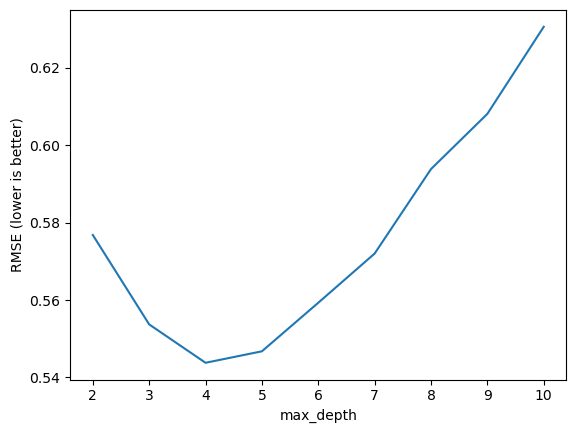

In [77]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_Scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')
plt.show()

### Building Final Decision Tree Model

In [78]:
# max_depth=4 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=4, random_state=345)
treereg.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=4, random_state=345)

In [79]:
treereg.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.39131526,
       0.16836295, 0.        , 0.00205615, 0.00181131, 0.43645434,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [80]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':data_new.columns.difference(['log_Total_Spend','Total_Spend']), 'importance':treereg.feature_importances_})

,feature,importance
0,gender,0.000000
1,log_card,0.000000
2,log_card2,0.000000
3,log_cardtenure,0.000000
4,log_income,0.391315
5,log_lnlongmon,0.168363
6,log_longten,0.000000
7,log_tenure,0.002056
8,ownvcr,0.001811
9,sq_internet,0.436454


In [81]:
### K-FOLD CROSS VALIDATION
scores = cross_val_score(treereg, train_X, train_y, cv=10, scoring='r2')
scores

array([0.27668733, 0.28254862, 0.30251955, 0.30005295, 0.25902061,
       0.33537059, 0.25463777, 0.35198342, 0.30649092, 0.27947301])

In [82]:
round( np.mean( cross_val_score( treereg,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.29)

## Creating a tree diagram

In [83]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_vehicles.png', feature_names=data_new.columns.difference(['log_Total_Spend','Total_Spend']))

## Making predictions for the testing data

In [84]:
pred = treereg.predict(train_X) 
y_pred = treereg.predict(test_X) 

In [85]:
# use fitted model to make predictions on testing data
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})  
dt

,Actual,Predicted
4133,6.289808,6.176941
3771,7.348768,6.757886
26,6.307497,6.176941
2049,5.730652,5.726945
3385,6.283294,6.992413
...,...,...
4001,5.989713,6.112519
2946,6.427734,6.651479
4987,6.043867,5.726945
2533,5.469030,5.726945


In [86]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4213833028647828
Mean Squared Error: 0.28167195716468796
Root Mean Squared Error: 0.5307277618183243


In [87]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",treereg.score(train_X, train_y))
print("R-squared for Test:",treereg.score(test_X, test_y))

R-squared for Train: 0.3283887472941778
R-squared for Test: 0.27364115172519765


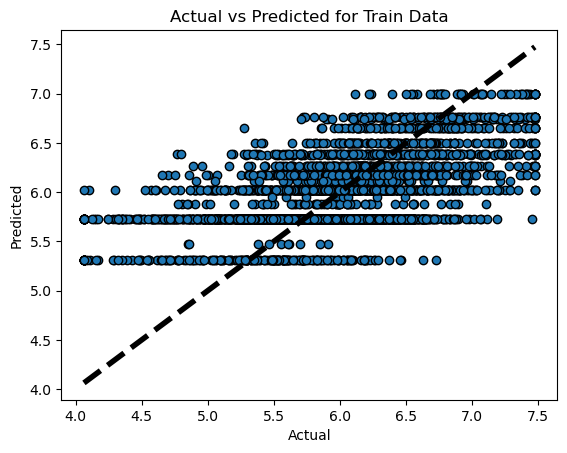

In [88]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

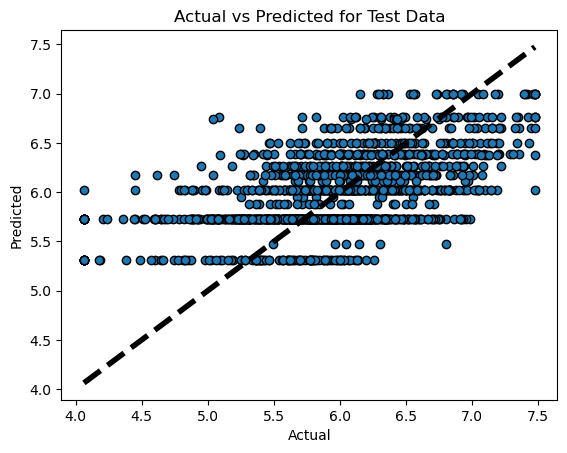

In [89]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# Random Forest (RF)

In [90]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=5,n_estimators=20, random_state=0)  
rfr.fit(train_X, train_y)  
y_pred = rfr.predict(test_X) 

In [91]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.41481532677407296
Mean Squared Error: 0.27461521439550396
Root Mean Squared Error: 0.5240374169804137


In [92]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",rfr.score(train_X, train_y))
print("R-squared for Test:",rfr.score(test_X, test_y))

R-squared for Train: 0.3618680988312055
R-squared for Test: 0.29183865921579644


### Tuning a Random Forest

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid={'max_depth': range(3,11),
            'n_estimators': (10, 50, 100)}

In [95]:
# Perform Grid-Search
gsc = GridSearchCV(estimator=RandomForestRegressor(),param_grid=param_grid,cv=5, verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(train_X, train_y)

In [96]:
grid_result.best_score_

np.float64(0.3123412403800721)

In [97]:
grid_result.best_params_

{'max_depth': 4, 'n_estimators': 100}

### Building Final Random Forest Model

In [98]:
rfr = RandomForestRegressor(max_depth=4,n_estimators=100, random_state=0)  
rfr.fit(train_X, train_y)  
pred=rfr.predict(train_X)
y_pred = rfr.predict(test_X) 

In [99]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':data_new.columns.difference(['log_Total_Spend','Total_Spend']), 'importance':rfr.feature_importances_})

,feature,importance
0,gender,0.000247
1,log_card,0.000047
2,log_card2,0.000806
3,log_cardtenure,0.002378
4,log_income,0.378484
5,log_lnlongmon,0.170917
6,log_longten,0.001827
7,log_tenure,0.002735
8,ownvcr,0.002349
9,sq_internet,0.431118


In [100]:
### K-FOLD CROSS VALIDATION
scores = cross_val_score(rfr, train_X, train_y, cv=10, scoring='r2')
scores

array([0.28344052, 0.2926594 , 0.32039582, 0.31534083, 0.2904629 ,
       0.34070526, 0.27585836, 0.35828737, 0.33332215, 0.29133867])

In [101]:
round( np.mean( cross_val_score( rfr,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.31)

In [102]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})  
dt

,Actual,Predicted
4133,6.289808,6.219536
3771,7.348768,6.745037
26,6.307497,6.138800
2049,5.730652,5.715447
3385,6.283294,6.924923
...,...,...
4001,5.989713,6.263958
2946,6.427734,6.630084
4987,6.043867,5.713848
2533,5.469030,5.678332


In [103]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4148738909910144
Mean Squared Error: 0.27473526674430127
Root Mean Squared Error: 0.5241519500529415


In [104]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",rfr.score(train_X, train_y))
print("R-squared for Test:",rfr.score(test_X, test_y))

R-squared for Train: 0.3403152672740941
R-squared for Test: 0.2915290753769121


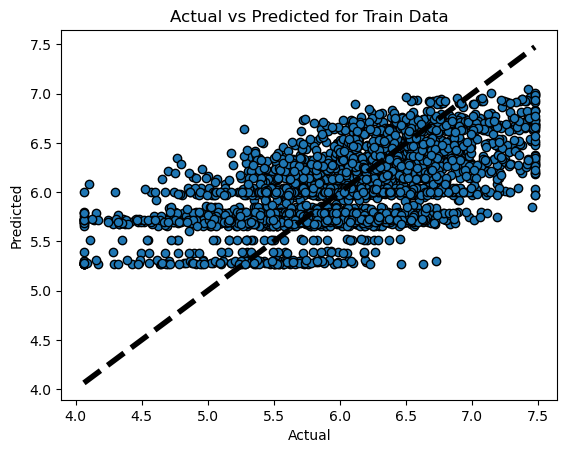

In [105]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

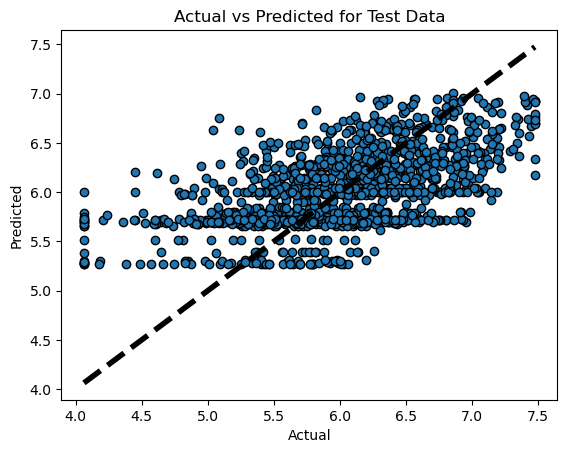

In [106]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# Gradient Boosting (GBM)

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit

In [108]:
gbrt=GradientBoostingRegressor()
gbrt.fit(train_X, train_y)
y_pred=gbrt.predict(test_X)

In [109]:
#One of the benefits of growing trees is that we can understand how important each of the features are
print(gbrt.feature_importances_)

[0.00372218 0.0017959  0.00351724 0.01707511 0.3283119  0.13002636
 0.01478451 0.02912244 0.01039842 0.40737613 0.01811372 0.01576808
 0.01302069 0.00295228 0.00401505]


In [110]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4125413672656567
Mean Squared Error: 0.2728524829759561
Root Mean Squared Error: 0.5223528337971912


In [111]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",gbrt.score(train_X, train_y))
print("R-squared for Test:",gbrt.score(test_X, test_y))

R-squared for Train: 0.4085177099504388
R-squared for Test: 0.29638428589659505


### Tuning a Gradient Boosting Model (GBM)

In [112]:
param_grid={'n_estimators' : [100,500],# 100,500,1000],
            'learning_rate' : [0.1,0.01],# 0.02,0.05,0.1],
            'max_depth' : [4,6]}# 5,6]

In [113]:
# Perform Grid-Search
gbr = GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=param_grid,cv=5)
    
grid_result = gbr.fit(train_X, train_y)

In [114]:
grid_result.best_score_

np.float64(0.30076887464329244)

In [115]:
grid_result.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}

### Building Final Gradient Boosting Model

In [116]:
gbrt=GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4)
gbrt.fit(train_X, train_y)
pred=gbrt.predict(train_X)
y_pred=gbrt.predict(test_X)

In [117]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':data_new.columns.difference(['log_Total_Spend','Total_Spend']), 'importance':gbrt.feature_importances_})

,feature,importance
0,gender,0.004361
1,log_card,0.002628
2,log_card2,0.005672
3,log_cardtenure,0.011179
4,log_income,0.326196
5,log_lnlongmon,0.139210
6,log_longten,0.012172
7,log_tenure,0.027638
8,ownvcr,0.016568
9,sq_internet,0.392359


In [118]:
# K Fold Cross Validation
scores = cross_val_score(gbrt, train_X, train_y, cv=10, scoring='r2')
scores

array([0.26976639, 0.28429776, 0.27638608, 0.32079402, 0.28198471,
       0.34219991, 0.27074566, 0.3434044 , 0.32740467, 0.29019838])

In [119]:
round( np.mean( cross_val_score( gbrt,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.3)

In [120]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})  
dt

,Actual,Predicted
4133,6.289808,6.214042
3771,7.348768,6.689415
26,6.307497,6.093184
2049,5.730652,5.736416
3385,6.283294,6.980758
...,...,...
4001,5.989713,6.232153
2946,6.427734,6.670002
4987,6.043867,5.612790
2533,5.469030,5.603054


In [121]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4145971328390378
Mean Squared Error: 0.27371333615175575
Root Mean Squared Error: 0.5231761999095101


In [122]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",gbrt.score(train_X, train_y))
print("R-squared for Test:",gbrt.score(test_X, test_y))

R-squared for Train: 0.4100061730844874
R-squared for Test: 0.2941643690557364


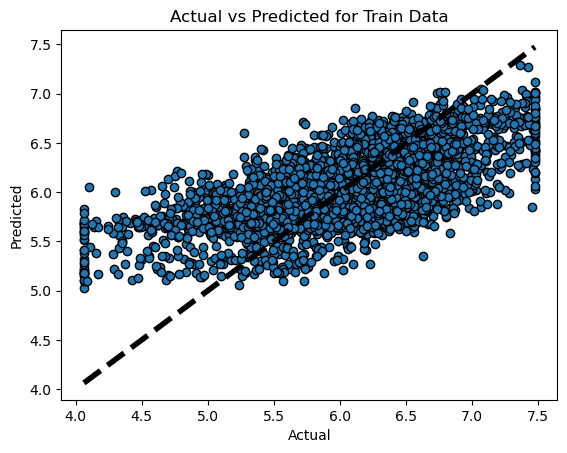

In [123]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

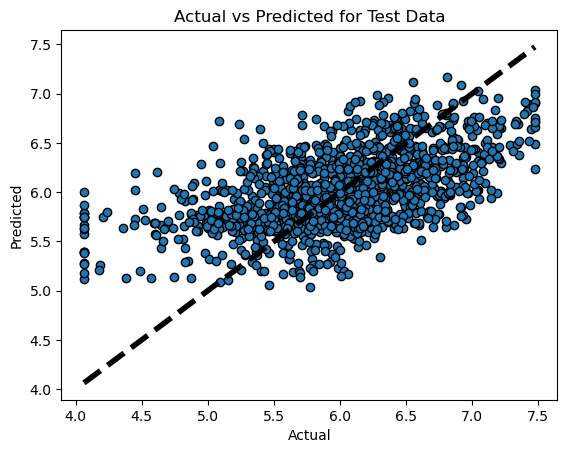

In [124]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# XGBOOST

In [126]:
# First, install the xgboost package
!pip install xgboost

# Then import it
import xgboost as xgb

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/101.7 MB 8.8 MB/s eta 0:00:12
   - -------------------------------------- 3.4/101.7 MB 10.9 MB/s eta 0:00:10
   -- ------------------------------------- 5.8/101.7 MB 11.3 MB/s eta 0:00:09
   --- ------------------------------------ 8.1/101.7 MB 11.5 MB/s eta 0:00:09
   ---- ----------------------------------- 10.5/101.7 MB 11.5 MB/s eta 0:00:08
   ----- ---------------------------------- 12.8/101.7 MB 11.6 MB/s eta 0:00:08
   ----- ---------------------------------- 14.4/101.7 MB 11.6 MB/s eta 0:00:08
   ------- -------------------------------- 17.8/101.7 MB 11.7 MB/s eta 0:00:08
   ------- -------------------------------- 20.2/101.7 MB 11.7 MB/s eta 0:00:07
   -------- ------------------------------- 22.5/101.7 MB 11.7 MB/s eta 0:00:07
   --------- ------------------------------ 24.9/101.7 MB 11.7 MB/s eta 0:00:07
   ---------- ----------------------------- 27.5/101.7

In [127]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
xg_reg.fit(train_X, train_y)
y_pred=xg_reg.predict(test_X)

In [128]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.45674990087446865
Mean Squared Error: 0.33073054946120767
Root Mean Squared Error: 0.5750917748161659


In [129]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",xg_reg.score(train_X, train_y))
print("R-squared for Test:",xg_reg.score(test_X, test_y))

R-squared for Train: 0.9048476365023942
R-squared for Test: 0.14713177905928976


### Tuning a XGBoost Model

In [130]:
xgb1 = xgb.XGBRegressor(objective='reg:squarederror')

In [131]:
parameters = {'n_estimators': [100,500],
            'learning_rate': [0.01,0.05,0.1], #so called `eta` value
            'max_depth': [4,5,6]}

In [132]:
xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,n_jobs = 5,verbose=True)

grid_result = xgb_grid.fit(train_X, train_y)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


In [133]:
print(xgb_grid.best_score_)

0.3005475337803366


In [134]:
print(xgb_grid.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


### Building Final XGBoost Model

In [135]:
xg_reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4,objective='reg:squarederror')
xg_reg.fit(train_X, train_y)
pred=xg_reg.predict(train_X)
y_pred=xg_reg.predict(test_X)

In [136]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':data_new.columns.difference(['log_Total_Spend','Total_Spend']), 'importance':xg_reg.feature_importances_})

,feature,importance
0,gender,0.028117
1,log_card,0.036582
2,log_card2,0.043776
3,log_cardtenure,0.036602
4,log_income,0.311618
5,log_lnlongmon,0.143004
6,log_longten,0.038098
7,log_tenure,0.040045
8,ownvcr,0.040202
9,sq_internet,0.140757


In [137]:
# K Fold Cross Validation
scores = cross_val_score(xg_reg, train_X, train_y, cv=10, scoring='r2')
scores

array([0.24427837, 0.24530062, 0.22698567, 0.31139425, 0.27563313,
       0.28451889, 0.2126032 , 0.31544778, 0.28039287, 0.26874216])

In [138]:
round( np.mean( cross_val_score( xg_reg,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.27)

In [139]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})  
dt

,Actual,Predicted
4133,6.289808,6.208413
3771,7.348768,6.742016
26,6.307497,6.227066
2049,5.730652,5.763894
3385,6.283294,7.077295
...,...,...
4001,5.989713,6.274978
2946,6.427734,6.754208
4987,6.043867,5.410248
2533,5.469030,5.563391


In [140]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.42331381578362615
Mean Squared Error: 0.28623865737891396
Root Mean Squared Error: 0.5350127637532716


In [141]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",xg_reg.score(train_X, train_y))
print("R-squared for Test:",xg_reg.score(test_X, test_y))

R-squared for Train: 0.6176318968448963
R-squared for Test: 0.2618648175050251


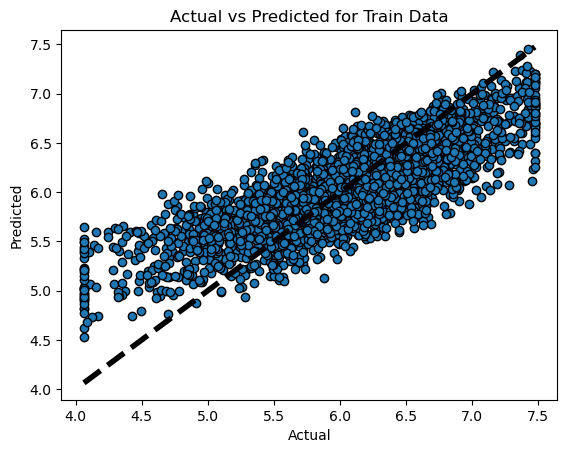

In [142]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

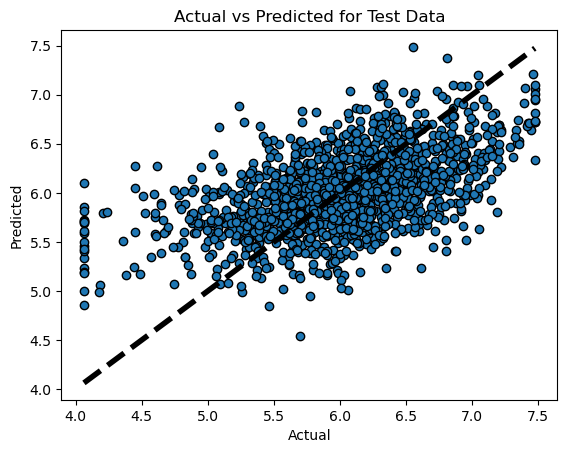

In [143]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# Support Vector Regression (SVR)

In [144]:
from sklearn.svm import SVR

In [145]:
svr = SVR(gamma='scale')
svr.fit(train_X, train_y)
y_pred=svr.predict(test_X)

In [146]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4808337898999124
Mean Squared Error: 0.38637937133667066
Root Mean Squared Error: 0.6215942175862568


In [147]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",svr.score(train_X, train_y))
print("R-squared for Test:",svr.score(test_X, test_y))

R-squared for Train: 0.012411376043467648
R-squared for Test: 0.003627915301643525


### Tuning a SVR Model

In [148]:
svr1 = SVR()

In [149]:
parameters = {'C':[1, 10, 100, 1000, 10000],
              'gamma': [1e-7, 1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
              'epsilon':[0.1,0.5]}

In [150]:
svr = GridSearchCV(svr1,parameters,cv=5)

grid_result = svr.fit(train_X, train_y)

In [151]:
print(svr.best_score_)

0.2111275741263401


In [152]:
print(svr.best_params_)

{'C': 10000, 'epsilon': 0.1, 'gamma': 1e-07}


### Building Final SVR Model

In [153]:
svr = SVR(C=10000, gamma=1e-07, epsilon=0.1)
svr.fit(train_X, train_y)
pred=svr.predict(train_X)
y_pred=svr.predict(test_X)

In [154]:
scores = cross_val_score(svr, train_X, train_y, cv=10, scoring='r2')
scores

array([0.215906  , 0.21158089, 0.22774138, 0.24658494, 0.18588628,
       0.25057815, 0.16883218, 0.19897215, 0.23475083, 0.19486659])

In [155]:
round( np.mean( cross_val_score( svr,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.21)

In [156]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
dt

,Actual,Predicted
4133,6.289808,6.041953
3771,7.348768,6.389746
26,6.307497,5.914544
2049,5.730652,5.920419
3385,6.283294,6.646729
...,...,...
4001,5.989713,5.897531
2946,6.427734,6.308201
4987,6.043867,5.800946
2533,5.469030,5.827287


In [157]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4231135727716928
Mean Squared Error: 0.2975965274447023
Root Mean Squared Error: 0.5455240851187987


In [158]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",svr.score(train_X, train_y))
print("R-squared for Test:",svr.score(test_X, test_y))

R-squared for Train: 0.2295880514529679
R-squared for Test: 0.23257581939927008


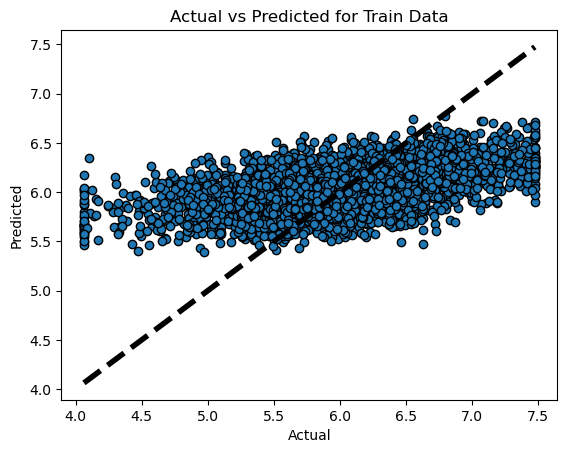

In [159]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

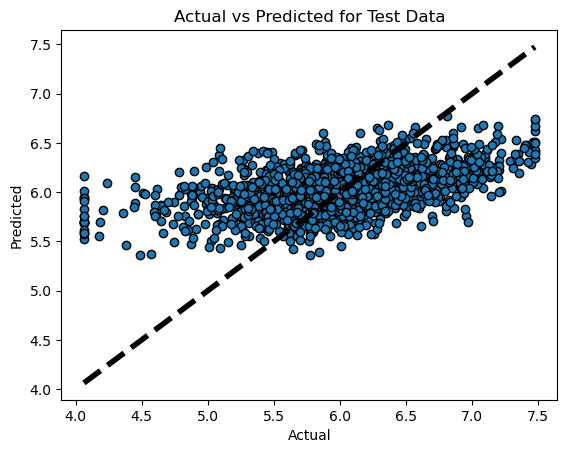

In [160]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# KNN

In [161]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [162]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(train_X, train_y)
y_pred=knn.predict(test_X)

In [163]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.4897066288343715
Mean Squared Error: 0.3899376909702942
Root Mean Squared Error: 0.6244499106976429


In [164]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",knn.score(train_X, train_y))
print("R-squared for Test:",knn.score(test_X, test_y))

R-squared for Train: 0.30713972466825157
R-squared for Test: -0.005548067202575613


### Tuning a KNN Model

In [165]:
rmse_val = [] #to store rmse values for different k
for K in range(20,70):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_X, train_y)  #fit the model
    pred=model.predict(test_X) #make prediction on test set
    error = sqrt(mean_squared_error(test_y,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  21 is: 0.5945473858234941
RMSE value for k=  22 is: 0.5939510991815922
RMSE value for k=  23 is: 0.5942563891483198
RMSE value for k=  24 is: 0.5948942785417207
RMSE value for k=  25 is: 0.5946702858421918
RMSE value for k=  26 is: 0.595871946203172
RMSE value for k=  27 is: 0.5956897822677506
RMSE value for k=  28 is: 0.5959269535278865
RMSE value for k=  29 is: 0.5969829691232769
RMSE value for k=  30 is: 0.597973233184008
RMSE value for k=  31 is: 0.5983157659393573
RMSE value for k=  32 is: 0.5984214835841905
RMSE value for k=  33 is: 0.5981615023316258
RMSE value for k=  34 is: 0.5984099018979694
RMSE value for k=  35 is: 0.598636210512329
RMSE value for k=  36 is: 0.5991338612432252
RMSE value for k=  37 is: 0.5997366775219712
RMSE value for k=  38 is: 0.600043007994911
RMSE value for k=  39 is: 0.6001960542575558
RMSE value for k=  40 is: 0.6001032239159287
RMSE value for k=  41 is: 0.6002109874005997
RMSE value for k=  42 is: 0.6000737570903409
RMSE value for

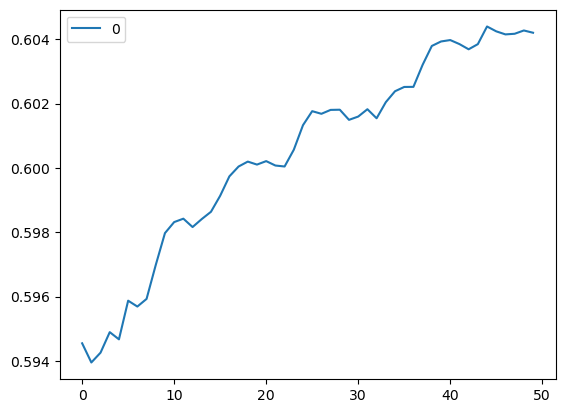

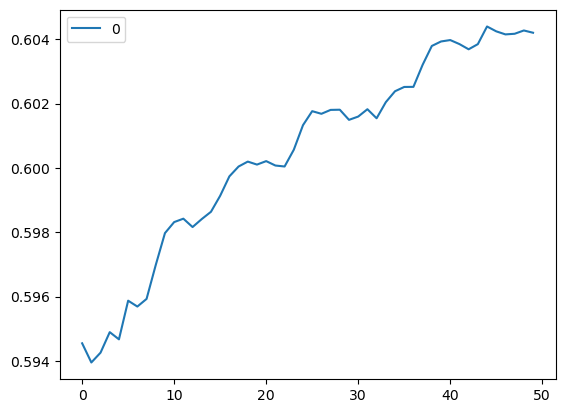

In [167]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()
plt.show()

### Building Final KNN Model

In [168]:
knn = neighbors.KNeighborsRegressor(n_neighbors=2)
knn.fit(train_X, train_y)
pred=knn.predict(train_X)
y_pred=knn.predict(test_X)

In [169]:
scores = cross_val_score(knn, train_X, train_y, cv=10, scoring='r2')
scores

array([-0.25330396, -0.45552754, -0.31347134, -0.11039586, -0.43900119,
       -0.46572564, -0.31795404, -0.22439053, -0.31608849, -0.27878126])

In [170]:
round( np.mean( cross_val_score( knn,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(-0.32)

In [171]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
dt

,Actual,Predicted
4133,6.289808,5.853805
3771,7.348768,6.515788
26,6.307497,6.204217
2049,5.730652,6.000888
3385,6.283294,5.718788
...,...,...
4001,5.989713,4.814310
2946,6.427734,5.949048
4987,6.043867,5.508141
2533,5.469030,6.148546


In [172]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.5558257839757733
Mean Squared Error: 0.4938982590895077
Root Mean Squared Error: 0.7027789546432844


In [173]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",knn.score(train_X, train_y))
print("R-squared for Test:",knn.score(test_X, test_y))

R-squared for Train: 0.568955983734418
R-squared for Test: -0.2736353815563979


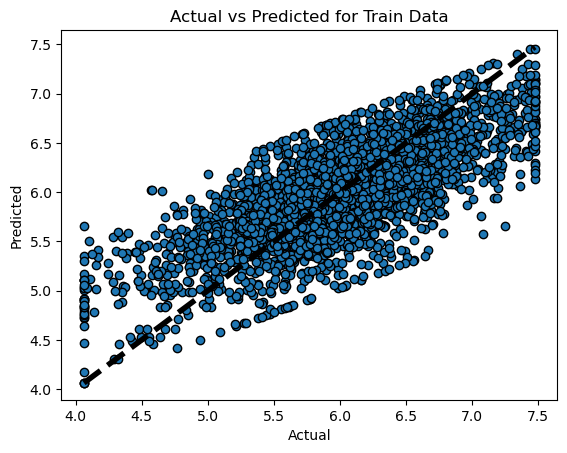

In [174]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

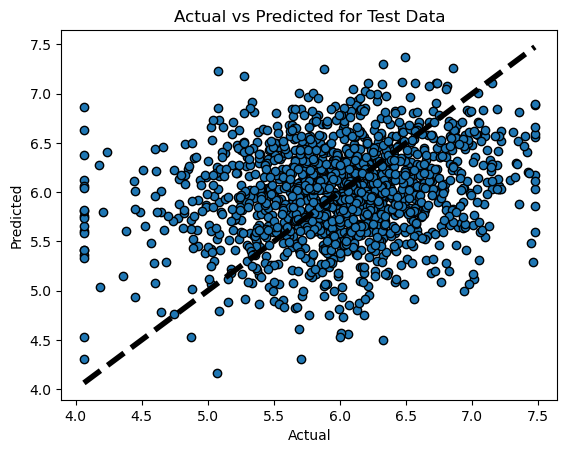

In [175]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# Neural Network

In [183]:
!pip install tensorflow

In [187]:
!pip install scikeras

In [188]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

In [189]:
def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units=1, input_dim=15))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae','accuracy'])
    return regressor

In [190]:
regressor = KerasRegressor(build_fn=build_regressor, batch_size=32,epochs=100)

In [191]:
# Ignore all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
results=regressor.fit(train_X,train_y)

Epoch 1/100


C:\Users\vg606\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\vg606\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.0000e+00 - loss: 377689.1562 - mae: 261.7049  
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.0000e+00 - loss: 205217.1719 - mae: 199.1042
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.0000e+00 - loss: 112185.8203 - mae: 153.2549
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.0000e+00 - loss: 60834.6211 - mae: 118.7555
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.0000e+00 - loss: 32527.8633 - mae: 93.0173
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.0000e+00 - loss: 17001.2051 - mae: 73.3765
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.0000e+00 - loss: 8783.2334 - mae: 58.1820 
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.0000e+00 - loss: 4685.1577 - mae: 47.1358
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.0000e+00 - loss: 2705.6404 - mae: 39.07

In [192]:
pred=regressor.predict(train_X)
y_pred= regressor.predict(test_X)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


In [193]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
dt

,Actual,Predicted
4133,6.289808,5.551817
3771,7.348768,5.746861
26,6.307497,6.096341
2049,5.730652,6.263594
3385,6.283294,6.310523
...,...,...
4001,5.989713,4.380224
2946,6.427734,6.372674
4987,6.043867,6.055628
2533,5.469030,5.930925


In [194]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.6657835996762539
Mean Squared Error: 0.7132709737127026
Root Mean Squared Error: 0.8445537127457925


In [195]:
# sum of square of residuals
ssr = np.sum((y_pred - test_y)**2)
print('sum of square of residuals : ',ssr)

#  total sum of squares
sst = np.sum((test_y - np.mean(test_y))**2)
print('total sum of squares : ',sst)

# R2 score
r2_score = 1 - (ssr/sst)
print('R2 score : ',r2_score)

sum of square of residuals :  1069.906460569054
total sum of squares :  581.6793403846374
R2 score :  -0.8393406577953666


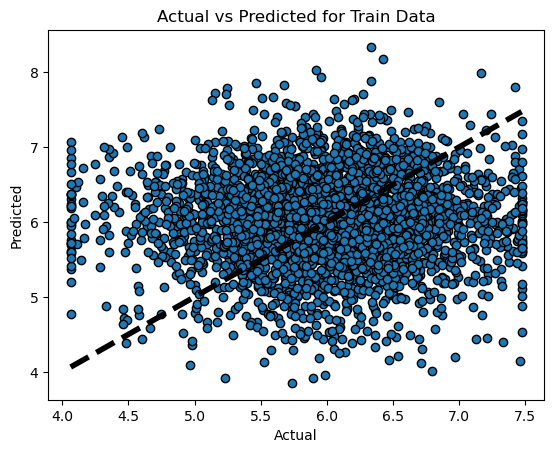

In [196]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

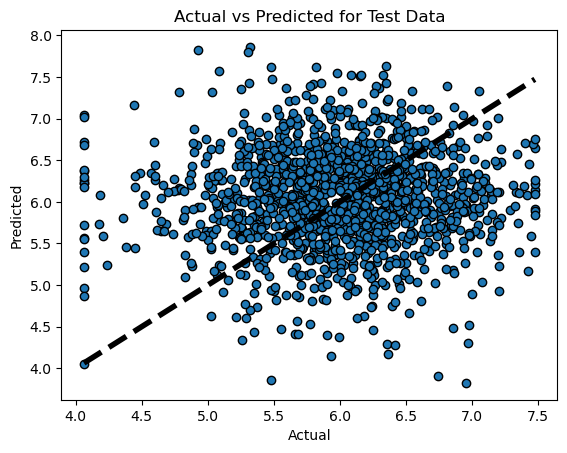

In [197]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

### Voting Regressor

In [198]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [199]:
X_train=np.array(train_X)

In [200]:
reg1 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=4)
reg2 = RandomForestRegressor(max_depth=4,n_estimators=50, random_state=0)
reg3 = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=4,objective='reg:squarederror')
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('xg', reg3)])
ereg = ereg.fit(X_train, train_y)

In [201]:
pred=ereg.predict(train_X)
y_pred= ereg.predict(test_X)

C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [202]:
scores = cross_val_score(ereg, train_X, train_y, cv=10, scoring='r2')
scores

array([0.27686799, 0.28952709, 0.29834132, 0.32388766, 0.29021538,
       0.34690345, 0.27319117, 0.35203839, 0.33172476, 0.29171122])

In [203]:
round( np.mean( cross_val_score( ereg,
                              train_X,
                              train_y,
                              scoring = 'r2',
                              cv = 10 ) ), 2 )

np.float64(0.31)

In [204]:
dt=pd.DataFrame({'Actual':test_y, 'Predicted':y_pred})
dt

,Actual,Predicted
4133,6.289808,6.222381
3771,7.348768,6.700322
26,6.307497,6.095968
2049,5.730652,5.728857
3385,6.283294,6.958441
...,...,...
4001,5.989713,6.255152
2946,6.427734,6.666592
4987,6.043867,5.645652
2533,5.469030,5.622088


In [205]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

Mean Absolute Error: 0.413329528048475
Mean Squared Error: 0.27210229642450434
Root Mean Squared Error: 0.521634255417054


In [206]:
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is.
print("R-squared for Train:",ereg.score(train_X, train_y))
print("R-squared for Test:",ereg.score(test_X, test_y))

R-squared for Train: 0.3876533696862363
R-squared for Test: 0.2983188222451503


C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\vg606\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


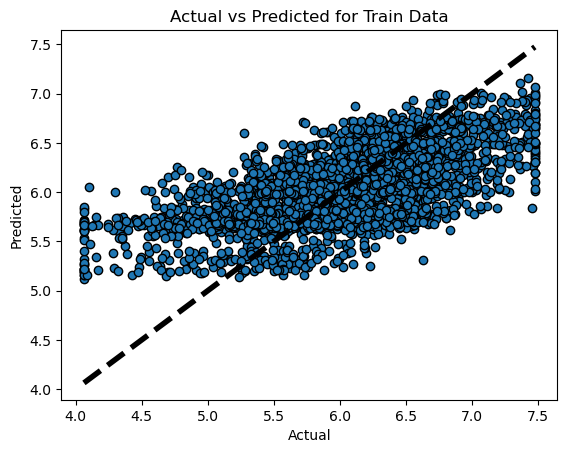

In [207]:
fig, ax = plt.subplots()
ax.scatter(train_y, pred, edgecolors=(0, 0, 0))
ax.plot([train_y.min(), train_y.max()], [train_y.min(), train_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Train Data")
plt.show()

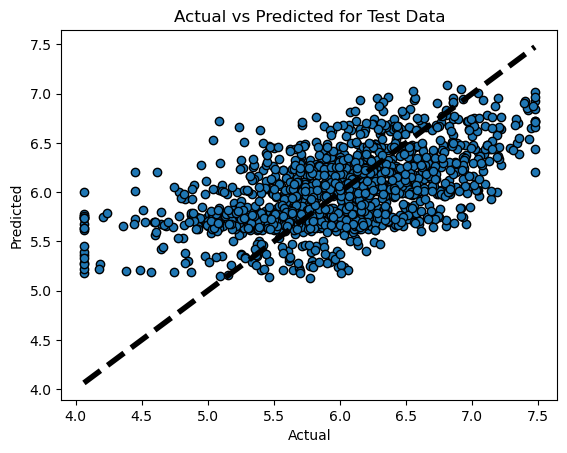

In [208]:
fig, ax = plt.subplots()
ax.scatter(test_y, y_pred, edgecolors=(0, 0, 0))
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted for Test Data")
plt.show()

# Save Model

In [209]:
import pickle

In [210]:
# save the model
filename = 'model.pkl'
pickle.dump(ereg, open(filename, 'wb'))

# Predict Model

In [211]:
model=pickle.load(open('model.pkl','rb'))
np.exp(model.predict(np.array([[0,1,0,3159.25,2,3,23,330.60,60,35,1.79,2,4,3,1]])))

array([999.95018291])